In [19]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
import xgboost as xgb

ROOT = ".."
import sys
sys.path.append(ROOT)
from src.data_utils import load_data

# INFOLDER = "./logs_augm_no_augm/real_xgb_only/"
INFOLDER = "./logs_augm_no_augm/real_test_set_1750672023/"

metrics  = [os.path.join(INFOLDER, x, "metrics.csv") for x in os.listdir(INFOLDER) if x.endswith("xgb_onehot")]
models = {x: os.path.join(INFOLDER, x, "model.xgboost") for x in os.listdir(INFOLDER) if x.endswith("xgb_onehot")}

In [20]:
X_test_cmd_file = os.path.join(INFOLDER, "test_cmd.pkl")

with open(X_test_cmd_file, "rb") as f:
    X_test_cmd = pickle.load(f)

y_test = np.load(f"{INFOLDER}/test_y.npy") 

print(len(X_test_cmd))
print(y_test.shape[0])

470129
470129


In [21]:
print("Loading augmented data...")
oh_augm = pickle.load(open(os.path.join(INFOLDER, "augm_onehot_4096.pkl"), "rb"))
X_test_augm = oh_augm.transform(X_test_cmd)

print("Loading non augmented data...")
oh_non_augm = pickle.load(open(os.path.join(INFOLDER, "not_augm_onehot_4096.pkl"), "rb"))
X_test_non_augm = oh_non_augm.transform(X_test_cmd)

Loading augmented data...
Loading non augmented data...


Loading model augm_xgb_onehot
Predicting...
Loading model not_augm_xgb_onehot
Predicting...
Loading model not_augm_balanced_xgb_onehot
Predicting...


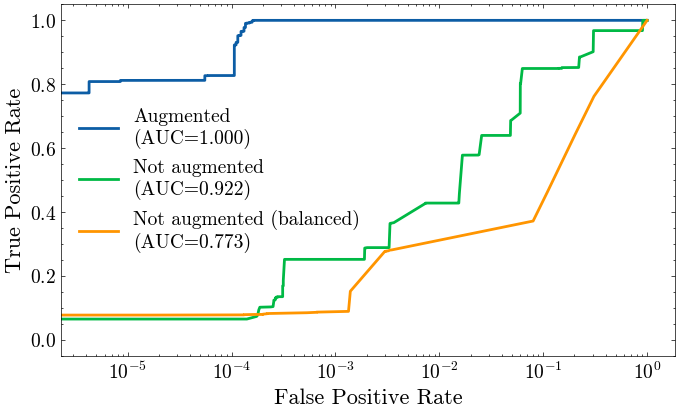

In [25]:
import scienceplots
plt.style.use(['science', 'no-latex'])

from src.plots import set_size

labelmap = {
    'augm': "Augmented",
    'not_augm': "Not augmented",
    'not_augm_balanced': "Not augmented (balanced)",
}

fig, ax = plt.subplots(figsize=set_size())
for name, label in labelmap.items():
    key = name + "_xgb_onehot"
    model_path = os.path.join(INFOLDER, key, "model.xgboost")
    print("Loading model {}".format(key))
    model = xgb.XGBClassifier()
    model.load_model(model_path)


    print("Predicting...")
    if "not" in key:
        # shuffle data
        X, y = shuffle(X_test_non_augm, y_test, random_state=42)
        y_pred = model.predict_proba(X)[:, 1]
    else:
        # shuffle data
        X, y = shuffle(X_test_augm, y_test, random_state=42)
        y_pred = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    ax.plot(fpr, tpr, label="{}\n(AUC={:.3f})".format(label, auc), lw=2)

# ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(fontsize=14)
# ax.grid(lw=0.5)

ax.semilogx()
# ax.grid(linewidth=0.5)
# ax.set_ylim([0.2, 1.05])

# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(16)

plt.tight_layout()
plt.savefig(f"../img/augm_non_augm_v3.pdf", dpi=300)